In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# Load validated schedule and processed sensor data
with open("/content/drive/MyDrive/SmartFactory/Results/Week8/week8_validated_schedule.json", 'r') as f:
    schedule_data = json.load(f)
schedule_df = pd.DataFrame(schedule_data)
schedule_df["rescheduled_time"] = pd.to_datetime(schedule_df["rescheduled_time"])

In [4]:
schedule_df.head()

,job_id,machine_id,original_time,rescheduled_time,duration,failure_prob,urgency_score,priority,delayed,delay_minutes,hour
0,JOB-A-M1A-0,A-M1A,1438344,1970-01-01 00:00:00.001438344,74,0.236,0.273,High,False,0.00000,0
1,JOB-A-M1A-20,A-M1A,1508994,1970-01-01 00:00:00.001508994,56,0.400,0.429,High,False,0.00000,0
2,JOB-A-M1A-40,A-M1A,1584829,1970-01-01 00:00:00.001584829,46,0.457,0.449,Medium,False,0.00000,0
3,JOB-A-M1A-60,A-M1A,1668822,1970-01-01 00:00:00.001668824,50,0.560,0.681,Medium,True,0.00003,0
4,JOB-A-OUX-0,A-OUX,1433552,1970-01-01 00:00:00.001433552,63,0.290,0.307,Low,False,0.00000,0


In [5]:
with open("/content/drive/MyDrive/SmartFactory/Dataset/processed_sensor_data.json", 'r') as f:
    sensor_data = json.load(f)
sensor_df = pd.DataFrame(sensor_data)
sensor_df["timestamp"] = pd.to_datetime(sensor_df["timestamp"])

In [6]:
sensor_df.head()

,timestamp,machine_id,temperature,vibration,rpm,pressure,humidity,voltage,failure,year,...,voltage_lag_1,voltage_lag_2,temperature_roc,vibration_roc,rpm_roc,pressure_roc,humidity_roc,voltage_roc,temperature_cummax,vibration_cummax
0,2015-05-26 20:55:13.644,B-MY9,71.47,0.94,2694,7.50,65.72,215.55,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.47,0.94
1,2015-05-27 20:15:37.644,N-PR7,64.60,2.44,3054,6.96,44.25,226.71,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.60,2.44
2,2015-05-28 07:53:40.644,Y-09D,76.14,1.93,2952,6.41,51.60,243.14,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.14,1.93
3,2015-05-29 09:45:29.644,X-PYA,73.72,1.87,2607,7.13,59.94,229.21,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.72,1.87
4,2015-05-30 06:22:48.644,G-2H4,77.37,0.57,3063,4.08,47.57,221.11,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.37,0.57


# Dashboard Data Preparation

In [7]:
# Aggregate daily failure counts by machine
failures = sensor_df[sensor_df["failure"] == 1].copy()
failures["date"] = failures["timestamp"].dt.date
daily_failures = failures.groupby(["date", "machine_id"]).size().reset_index(name="failures_count")

In [8]:
# Job count and delay per machine daily
schedule_df["date"] = schedule_df["rescheduled_time"].dt.date
jobs_per_day = schedule_df.groupby(["date", "machine_id"]).agg(
    jobs_scheduled=pd.NamedAgg(column="job_id", aggfunc="count"),
    avg_delay=pd.NamedAgg(column="delay_minutes", aggfunc="mean"),
    avg_failure_prob=pd.NamedAgg(column="failure_prob", aggfunc="mean")
).reset_index()

 # Failure Trends Visualization (Line + Bar)

In [9]:
fig_fail_trend = sp.make_subplots(rows=2, cols=1,
                                 subplot_titles=("Daily Failure Counts by Machine",
                                                 "Total Failures per Machine"),
                                 specs=[[{"type": "scatter"}],
                                        [{"type": "bar"}]])

for machine in daily_failures['machine_id'].unique():
    df_m = daily_failures[daily_failures['machine_id'] == machine]
    fig_fail_trend.add_trace(go.Scatter(x=df_m['date'], y=df_m['failures_count'], mode='lines+markers', name=machine), row=1, col=1)

total_failures = daily_failures.groupby('machine_id')['failures_count'].sum().sort_values(ascending=False)
fig_fail_trend.add_trace(go.Bar(x=total_failures.index, y=total_failures.values, marker_color='crimson'), row=2, col=1)

fig_fail_trend.update_layout(height=600, title_text="Failure Trends Overview")
fig_fail_trend.update_xaxes(title_text="Date", row=1, col=1)
fig_fail_trend.update_yaxes(title_text="Failures Count", row=1, col=1)
fig_fail_trend.update_yaxes(title_text="Total Failures", row=2, col=1)

fig_fail_trend.write_html("/content/drive/MyDrive/SmartFactory/Results/Week9/Dashboards/failure_trends_overview.html")

In [10]:
fig_fail_trend.show()

# Heatmaps for Job Scheduling Load and Delay

In [11]:
pivot_jobs = jobs_per_day.pivot(index="machine_id", columns="date", values="jobs_scheduled").fillna(0)
pivot_delay = jobs_per_day.pivot(index="machine_id", columns="date", values="avg_delay").fillna(0)

fig_jobs_heatmap = go.Figure(data=go.Heatmap(
    z=pivot_jobs.values,
    x=[str(d) for d in pivot_jobs.columns],
    y=pivot_jobs.index,
    colorscale='Viridis',
    colorbar=dict(title="Jobs Scheduled"),
))
fig_jobs_heatmap.update_layout(title="Jobs Scheduled per Machine per Day", xaxis_nticks=20)
fig_jobs_heatmap.write_html("/content/drive/MyDrive/SmartFactory/Results/Week9/Dashboards/jobs_heatmap.html")
fig_jobs_heatmap.show()

In [12]:
fig_delay_heatmap = go.Figure(data=go.Heatmap(
    z=pivot_delay.values,
    x=[str(d) for d in pivot_delay.columns],
    y=pivot_delay.index,
    colorscale='RdYlGn_r',
    colorbar=dict(title="Average Delay (min)"),
))
fig_delay_heatmap.update_layout(title="Average Delay per Machine per Day", xaxis_nticks=20)
fig_delay_heatmap.write_html("/content/drive/MyDrive/SmartFactory/Results/Week9/Dashboards/delay_heatmap.html")
fig_delay_heatmap.show()

# Job Priority & Failure Probability Visualizations

In [13]:
priority_counts = schedule_df['priority'].value_counts().reset_index()
priority_counts.columns = ['priority', 'count']

fig_priority_pie = px.pie(priority_counts, values='count', names='priority',
                         title='Distribution of Job Priorities')
fig_priority_pie.write_html("/content/drive/MyDrive/SmartFactory/Results/Week9/Dashboards/priority_distribution.html")
fig_priority_pie.show()

In [14]:
fig_fail_delay = px.scatter(schedule_df, x='failure_prob', y='delay_minutes',
                            color='priority', size='failure_prob',
                            title='Failure Probability vs. Delay Minutes',
                            labels={'failure_prob': 'Failure Probability', 'delay_minutes': 'Delay (min)'})
fig_fail_delay.write_html("/content/drive/MyDrive/SmartFactory/Results/Week9/Dashboards/failure_delay_scatter.html")
fig_fail_delay.show()

# PCA for Sensor Feature Reduction (For Training)

In [15]:
sensor_features = [
    "temperature", "vibration", "rpm", "pressure", "humidity", "voltage",
    "temperature_rolling_mean", "vibration_rolling_mean", "rpm_rolling_mean",
    "pressure_rolling_mean", "humidity_rolling_mean", "voltage_rolling_mean"
]

sensor_clean = sensor_df.dropna(subset=sensor_features)

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sensor_clean[sensor_features])

In [17]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

In [18]:
sensor_clean['pca_1'] = pca_result[:, 0]
sensor_clean['pca_2'] = pca_result[:, 1]

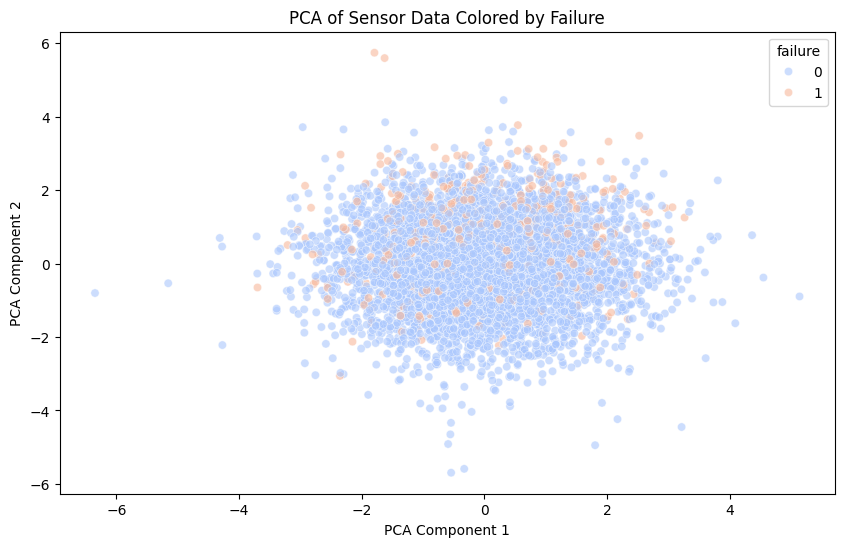

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=sensor_clean, x='pca_1', y='pca_2', hue='failure', palette='coolwarm', alpha=0.6)
plt.title('PCA of Sensor Data Colored by Failure')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("/content/drive/MyDrive/SmartFactory/Results/Week9/UserGuide/pca_sensor_data.png")
plt.show()

# Sensor Behavior Around Failures

In [20]:
sensor_window = sensor_df.copy()
sensor_window['time_to_failure'] = np.nan

In [21]:
# Calculate time to failure for each sensor reading
for idx, row in failures.iterrows():
    mask = (
        (sensor_window['machine_id'] == row['machine_id']) &
        (sensor_window['timestamp'] <= row['timestamp']) &
        (sensor_window['timestamp'] > row['timestamp'] - pd.Timedelta(hours=6))
    )
    sensor_window.loc[mask, 'time_to_failure'] = (
        (row['timestamp'] - sensor_window.loc[mask, 'timestamp']).dt.total_seconds() / 60
    )

# Filter readings that have a time_to_failure calculated
sensor_pre_fail = sensor_window.dropna(subset=['time_to_failure'])

# List of sensor features to plot
features = ['temperature', 'vibration', 'rpm', 'pressure', 'humidity']

# Plot each sensor feature
for feature in features:
    fig = px.line(
        sensor_pre_fail,
        x='time_to_failure',
        y=feature,
        color='machine_id',
        title=f'{feature.capitalize()} Trends 6 Hours Before Failure',
        labels={
            'time_to_failure': 'Minutes Before Failure',
            feature: feature.capitalize(),
            'machine_id': 'Machine ID'
        },
        markers=True
    )

    # Reverse X-axis to show minutes before failure
    fig.update_layout(
        xaxis_title='Minutes Before Failure',
        yaxis_title=feature.capitalize(),
        xaxis_autorange='reversed',
        legend_title_text='Machine ID',
        legend=dict(
            yanchor='top',
            y=1,
            xanchor='left',
            x=1.02,
            itemsizing='constant',
        )
    )

    # Save as interactive HTML file
    fig.write_html(f"/content/drive/MyDrive/SmartFactory/Results/Week9/UserGuide/{feature}_pre_failure_trends.html")
    fig.show()

# Correlation Matrix & Feature Importance

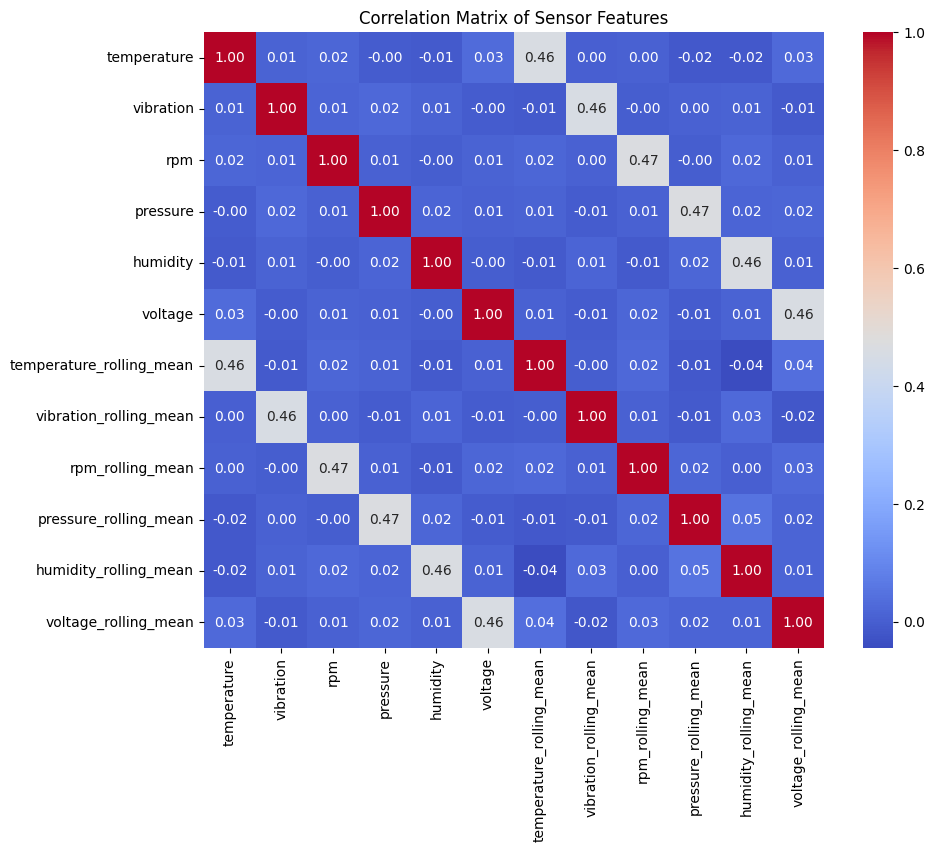

In [22]:
# Correlation matrix heatmap
corr = sensor_df[sensor_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Sensor Features')
plt.savefig("/content/drive/MyDrive/SmartFactory/Results/Week9/UserGuide/correlation_matrix.png")
plt.show()
plt.close()

In [23]:
# Feature importance from Random Forest (from week 3 model)
from sklearn.ensemble import RandomForestClassifier

In [24]:
# Prepare data
rf_features = sensor_features
X_rf = sensor_df[rf_features].ffill().bfill()
y_rf = sensor_df['failure']

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_rf, y_rf)

RandomForestClassifier(random_state=42)

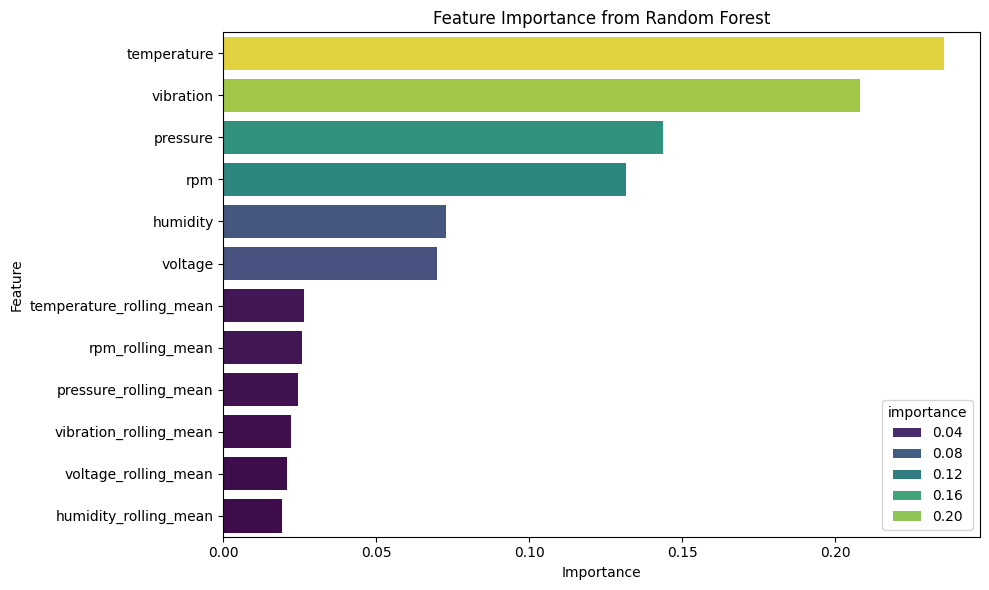

In [25]:
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({'feature': rf_features, 'importance': importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='importance', y='feature', hue = 'importance', palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/SmartFactory/Results/Week9/UserGuide/feature_importance_rf.png")
plt.show()
plt.close()

# Staff Training Notes

In [26]:
training_notes = """
SmartFactory.AI Staff Training - Extended Edition:

1. Failure Trends:
   - Review daily failure counts and total failures per machine.
   - Identify machines with high failure frequency for prioritized monitoring.

2. Scheduling Insights:
   - Monitor workload distribution and delays via heatmaps.
   - Understand impact of job priorities on scheduling and delays.

3. Sensor Data Analysis:
   - Examine PCA results for sensor data dimension reduction.
   - Interpret sensor trends leading to failures to predict maintenance needs.

4. Correlation and Feature Impact:
   - Use correlation matrices to understand sensor interdependencies.
   - Prioritize features based on model-derived importance for focused monitoring.

5. Practical Applications:
   - Use dashboards to guide rescheduling and preventive maintenance.
   - Apply training visuals to recognize early failure signals.

6. Training Materials:
   - Review saved plots and dashboards regularly.
   - Access detailed image resources in the training_materials directory.

For more interactive sessions and quizzes, access the SmartFactory Learning Portal.

"""

In [27]:
with open("/content/drive/MyDrive/SmartFactory/Results/Week9/UserGuide/training_notes_extended.txt", "w") as file:
    file.write(training_notes)

print("Extended Week 9 dashboards, visuals, and training notes created.")

Extended Week 9 dashboards, visuals, and training notes created.
